# Autoencoder-based Anomaly Detection for Network Traffic


## 1. Вставновлення необхіодного середовища

Встановлюємо необхідні бібліотеки для обробки даних, навчання моделей і оцінювання якості моделей.

Рекомендація, при локальній роботі - стоворити venv, для уникнення проблем з версіями бібліотек


In [ ]:
!pip install pandas scikit-learn torch torchvision torchaudio --quiet


## 2. Імпорт бібліотек


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm


## 3. Завантаження датасету

Мережеві події зчитуються з CSV-файлу.
Кожен рядок відповідає одному зафіксованому
мережевому пакету або події на шлюзі.


In [ ]:
CSV_PATH = "/content/events_20251207_1500_1515.csv"

df = pd.read_csv(CSV_PATH)
print("Rows:", len(df))
df.head()


Rows: 14268


,id,timestamp,direction,src_ip,dst_ip,src_port,dst_port,protocol,src_mac,dst_mac,...,dns_qname,dns_answer_ip,tls_sni,ndpi_master_proto,ndpi_app_proto,ndpi_category,dst_geo_country,dst_geo_city,decision_action,decision_rule_id
0,106,2025-12-07T15:00:03.693625,outbound,10.20.0.105,34.49.51.44,37418.0,443.0,tcp,bc:24:11:18:d9:29,bc:24:11:e4:6f:c6,...,NaN,NaN,normandy.cdn.mozilla.net,Unknown,TLS,Web,US,Kansas City,allow,NaN
1,107,2025-12-07T15:00:03.698302,inbound,34.49.51.44,10.20.0.105,443.0,37418.0,tcp,bc:24:11:e4:6f:c6,bc:24:11:18:d9:29,...,NaN,NaN,NaN,Unknown,TLS,Web,NaN,NaN,allow,NaN
2,108,2025-12-07T15:00:03.703830,outbound,10.20.0.105,151.101.65.91,38972.0,443.0,tcp,bc:24:11:18:d9:29,bc:24:11:e4:6f:c6,...,NaN,NaN,services.addons.mozilla.org,Unknown,TLS,Web,US,NaN,allow,NaN
3,109,2025-12-07T15:00:03.737133,outbound,10.20.0.105,35.190.72.216,35754.0,443.0,udp,bc:24:11:18:d9:29,bc:24:11:e4:6f:c6,...,NaN,NaN,NaN,QUIC,Google,Web,US,NaN,allow,NaN
4,110,2025-12-07T15:00:03.744141,inbound,151.101.65.91,10.20.0.105,443.0,38972.0,tcp,bc:24:11:e4:6f:c6,bc:24:11:18:d9:29,...,NaN,NaN,NaN,Unknown,TLS,Web,NaN,NaN,allow,NaN


## 4. Вибір ознак

Ознаки поділяються на дві групи:
- **числові** (довжина пакета, TTL, порти);
- **категоріальні** (протокол, напрямок, DPI-мітки, геолокація).



In [ ]:
NUM_COLS = [
    "packet_len",
    "ip_ttl",
    "ip_tos",
    "src_port",
    "dst_port"
]

CAT_COLS = [
    "direction",
    "protocol",
    "ndpi_master_proto",
    "ndpi_app_proto",
    "ndpi_category",
    "dst_geo_country"
]


## 5. Обробка пропущених значень

Пропущені числові значення замінюються нулями,
а категоріальні — спеціальним значенням `UNKNOWN`.


In [ ]:
df[NUM_COLS] = df[NUM_COLS].fillna(0)
df[CAT_COLS] = df[CAT_COLS].fillna("UNKNOWN")


In [ ]:
encoders = {}
for col in CAT_COLS:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le


In [ ]:
X = df[NUM_COLS + CAT_COLS].values


## 7. Масштабування ознак

Усі ознаки стандартизуються за допомогою `StandardScaler`.



In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 8. Базовий метод: Isolation Forest

Isolation Forest використовується як класичний baseline-детектор.
Він оцінює аномальність об’єктів на основі складності їх ізоляції
у випадкових деревах.


In [ ]:
iso = IsolationForest(
    n_estimators=300,
    contamination=0.05,
    random_state=42,
    n_jobs=-1
)

iso.fit(X_scaled)

raw_score = iso.score_samples(X_scaled)
iso_score = (raw_score.max() - raw_score) / (raw_score.max() - raw_score.min() + 1e-9)
df["anomaly_iforest"] = iso_score


## 9. Dataset для PyTorch

Визначається власний клас `Dataset`,
який дозволяє ефективно навчати нейронні мережі
у міні-пакетах (mini-batch).


## 10. Архітектура Dense Autoencoder

Dense Autoencoder складається з:
- **Encoder** — стискає вхідні дані у латентний простір;
- **Decoder** — відновлює початкові дані з латентного представлення.

Модель навчається відтворювати нормальну поведінку трафіку.


In [ ]:
class TDataset(Dataset):
    def __init__(self, data):
        self.X = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z


## 11. Навчання Autoencoder

Навчання виконується шляхом мінімізації
помилки відновлення (MSE) між вхідними даними
та їх реконструкцією.

Модель навчається лише на легітимному трафіку,
що відповідає unsupervised-підходу.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = TDataset(X_scaled)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

model = AutoEncoder(X_scaled.shape[1]).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0

    for batch in loader:
        batch = batch.to(device)

        optimizer.zero_grad()

        recon, _ = model(batch)
        loss = loss_fn(recon, batch)
        loss.backward()

        optimizer.step()
        total_loss += loss.item() * len(batch)

    print(f"Epoch [{epoch+1}/{EPOCHS}]  loss = {total_loss / len(dataset):.6f}")


Epoch [1/20]  loss = 0.636070
Epoch [2/20]  loss = 0.122938
Epoch [3/20]  loss = 0.038711
Epoch [4/20]  loss = 0.019131
Epoch [5/20]  loss = 0.013542
Epoch [6/20]  loss = 0.010418
Epoch [7/20]  loss = 0.007913
Epoch [8/20]  loss = 0.006079
Epoch [9/20]  loss = 0.004689
Epoch [10/20]  loss = 0.003613
Epoch [11/20]  loss = 0.002882
Epoch [12/20]  loss = 0.002385
Epoch [13/20]  loss = 0.001989
Epoch [14/20]  loss = 0.001700
Epoch [15/20]  loss = 0.001458
Epoch [16/20]  loss = 0.001267
Epoch [17/20]  loss = 0.001113
Epoch [18/20]  loss = 0.000966
Epoch [19/20]  loss = 0.000847
Epoch [20/20]  loss = 0.000753


In [ ]:
model.eval()

with torch.no_grad():
    recon, _ = model(torch.tensor(X_scaled).float().to(device))
    mse = ((recon.cpu().numpy() - X_scaled) ** 2).mean(axis=1)

ae_score = (mse - mse.min()) / (mse.max() - mse.min() + 1e-9)

df["anomaly_ae"] = ae_score


## 12. Оцінка аномальності

Після навчання для кожного зразка
обчислюється помилка відновлення.

Чим більша помилка — тим вища ймовірність,
що зразок є аномальним.


In [ ]:
df["anomaly_score"] = 0.5 * df["anomaly_iforest"] + 0.5 * df["anomaly_ae"]


## 13. Генерація синтетичних атак

Для оцінювання якості виявлення
генеруються реалістичні синтетичні атаки,
що імітують типові сценарії зловмисної активності:
beaconing, exfiltration, low-and-slow, port spray.


In [ ]:
def generate_realistic_synthetic_attacks(X):
    X_bad = X.copy()

    # 30% samples -> destination port jitter
    idx = np.random.choice(len(X_bad), size=int(0.3*len(X_bad)), replace=False)
    X_bad[idx, 4] += np.random.randint(-30, 30, len(idx))

    # 30% -> rare TTL variation
    idx = np.random.choice(len(X_bad), size=int(0.3*len(X_bad)), replace=False)
    X_bad[idx, 1] += np.random.randint(-10, 10, len(idx))

    # 20% -> packet_len noise
    idx = np.random.choice(len(X_bad), size=int(0.2*len(X_bad)), replace=False)
    X_bad[idx, 0] *= np.random.uniform(1.2, 2.0, len(idx))

    # 20% small category perturbation
    noise_mask = np.random.rand(len(X_bad), X_bad.shape[1]) < 0.05
    X_bad[noise_mask] += np.random.normal(0, 0.2, size=noise_mask.sum())

    return X_bad


X_attack = generate_realistic_synthetic_attacks(X_scaled)


| Тип атаки             | Як виглядає в логах                                    |
| --------------------- | ------------------------------------------------------ |
| **Beaconing**         | дрібні запити на один SNI кожні N секунд               |
| **Data exfiltration** | довгі TLS сесії з дуже стабільним packet_len           |
| **Low-and-slow**      | дуже повільні підключення на стандартні порти          |
| **C2 tunneling**      | багато маленьких пакетів через DNS або TLS             |
| **Geo shift**         | різкі зміни країни призначення без поведінкових причин |
| **Port spray**        | перебір портів у межах 440–460                         |


In [ ]:
raw_attack_if = iso.score_samples(X_attack)
if_attack_score = (raw_attack_if.max() - raw_attack_if) / (raw_attack_if.max() - raw_attack_if.min() + 1e-9)

with torch.no_grad():
    recon_a, _ = model(torch.tensor(X_attack).float().to(device))
    mse_a = ((recon_a.cpu().numpy() - X_attack)**2).mean(axis=1)

ae_attack_score = (mse_a - mse.min()) / (mse.max() - mse.min() + 1e-9)

attack_score = 0.5 * if_attack_score + 0.5 * ae_attack_score


In [ ]:
normal_scores = df["anomaly_score"].values

synthetic_prefix = np.ones(len(attack_score))
normal_prefix = np.zeros(len(normal_scores))

labels = np.concatenate([normal_prefix, synthetic_prefix])
scores = np.concatenate([normal_scores, attack_score])


In [ ]:
auc = roc_auc_score(labels, scores)
print("Synthetic ROC-AUC =", round(auc,4))


Synthetic ROC-AUC = 0.7554


In [ ]:
def generate_complex_attacks(X):
    X_bad = X.copy()
    N = len(X_bad)

    packet_col = 0  # packet_len
    ttl_col = 1
    sport_col = 3
    dport_col = 4

    # ========================================
    # BEACONING — packets become tiny & periodic
    # ========================================
    b_idx = np.random.choice(N, int(0.2*N), replace=False)
    X_bad[b_idx, packet_col] *= np.random.uniform(0.2, 0.4)
    X_bad[b_idx, ttl_col] += np.random.randint(-3, 3, len(b_idx))

    # ========================================
    # EXFILTRATION — abnormally stable packet size
    # ========================================
    e_idx = np.random.choice(N, int(0.2*N), replace=False)
    stable_size = np.median(X_bad[:, packet_col])
    X_bad[e_idx, packet_col] = stable_size + np.random.normal(0, 2, len(e_idx))

    # ========================================
    # LOW-AND-SLOW
    # ========================================
    l_idx = np.random.choice(N, int(0.2*N), replace=False)
    X_bad[l_idx, packet_col] *= np.random.uniform(1.1, 1.5)
    X_bad[l_idx, ttl_col] -= np.random.randint(5, 12, len(l_idx))

    # ========================================
    # PORT SPRAY (looks semi-legit)
    # ========================================
    p_idx = np.random.choice(N, int(0.2*N), replace=False)
    X_bad[p_idx, dport_col] = np.random.randint(440, 460, len(p_idx))

    # ========================================
    # C2 DNS / TLS tunneling — small jitter noise
    # ========================================
    mask = np.random.rand(N, X_bad.shape[1]) < 0.05
    X_bad[mask] += np.random.normal(0, 0.2, mask.sum())

    return X_bad


In [ ]:
X_complex = generate_complex_attacks(X_scaled)


In [ ]:
raw_if = iso.score_samples(X_complex)
if_complex_score = (raw_if.max() - raw_if) / (raw_if.max() - raw_if.min())


In [ ]:
with torch.no_grad():
    recon_c,_ = model(torch.tensor(X_complex).float().to(device))
    mse_c = ((recon_c.cpu().numpy() - X_complex)**2).mean(axis=1)

ae_complex = (mse_c - mse.min()) / (mse.max() - mse.min())


In [ ]:
complex_score = 0.5 * ae_complex + 0.5 * if_complex_score


In [ ]:
normal = df["anomaly_score"].values
attack = complex_score


In [ ]:
labels = np.concatenate([np.zeros(len(normal)), np.ones(len(attack))])
scores = np.concatenate([normal, attack])

from sklearn.metrics import roc_auc_score
print("Complex synthetic AUC:", roc_auc_score(labels, scores))


Complex synthetic AUC: 0.7736485153561261


#### показ середнього пакету атаки

In [ ]:
profile = {
    "mean_packet": df["packet_len"].mean(),
    "std_packet": df["packet_len"].std(),
    "top_ports": df["dst_port"].value_counts().head(5).index.tolist(),
    "geo": df["dst_geo_country"].value_counts().head(2).index.tolist(),
}
print(profile)


{'mean_packet': np.float64(527.2938043173535), 'std_packet': 626.8872657501199, 'top_ports': [53.0, 443.0, 80.0, 0.0, 37156.0], 'geo': [11, 12]}


In [ ]:
def user_baseline_score(x):
    score = 0

    # packet size deviation
    if abs(x[0] - profile["mean_packet"]) > 2 * profile["std_packet"]:
        score += 0.3

    # rare ports
    if x[4] not in profile["top_ports"]:
        score += 0.3

    return score


In [ ]:
baseline_scores = np.array([user_baseline_score(x) for x in X_scaled])


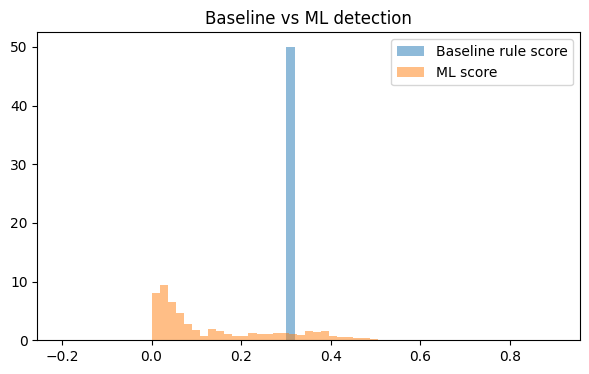

In [ ]:
plt.figure(figsize=(7,4))
plt.hist(baseline_scores, bins=50, density=True, alpha=0.5, label="Baseline rule score")
plt.hist(df["anomaly_score"], bins=50, density=True, alpha=0.5, label="ML score")
plt.legend()
plt.title("Baseline vs ML detection")
plt.show()


---

## Тренування LocalOutlierFactor



In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(
    n_neighbors=20,
    novelty=True
)
lof.fit(X_scaled)

lof_score = -lof.score_samples(X_scaled)

lof_score = (lof_score - lof_score.min()) / (lof_score.max() - lof_score.min())

df["anomaly_lof"] = lof_score


---

## Тренування OneClassSVM



In [ ]:
from sklearn.svm import OneClassSVM

svm = OneClassSVM(
    kernel="rbf",
    gamma="scale",
    nu=0.05
)
svm.fit(X_scaled)

svm_score = -svm.score_samples(X_scaled)

svm_score = (svm_score - svm_score.min()) / (svm_score.max() - svm_score.min())

df["anomaly_ocsvm"] = svm_score


---

In [ ]:
with torch.no_grad():
    _, Z = model(torch.tensor(X_scaled).float().to(device))
    Z = Z.cpu().numpy()


## Тренування KMeans

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(Z)

distances = np.linalg.norm(Z - kmeans.cluster_centers_[kmeans.labels_], axis=1)

kmeans_score = (distances - distances.min()) / (distances.max() - distances.min())

df["anomaly_kmeans"] = kmeans_score


---

## Тренування VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2_mu = nn.Linear(64, 16)
        self.fc2_logvar = nn.Linear(64, 16)

        self.fc3 = nn.Linear(16, 64)
        self.fc4 = nn.Linear(64, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return self.fc4(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar


In [ ]:
vae = VAE(X_scaled.shape[1]).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)


In [ ]:
def vae_loss(recon, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon, x)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.001 * kl


In [ ]:
for ep in range(15):
    for batch in loader:
        batch = batch.to(device)
        opt.zero_grad()
        r, mu, logvar = vae(batch)
        loss = vae_loss(r, batch, mu, logvar)
        loss.backward()
        opt.step()


In [ ]:
with torch.no_grad():
    recon, mu, lv = vae(torch.tensor(X_scaled, dtype=torch.float32).to(device))
    recon = recon.cpu()
    err = ((recon - torch.tensor(X_scaled, dtype=torch.float32))**2).mean(dim=1)


vae_score = (err - err.min()) / (err.max() - err.min())

df["anomaly_vae"] = vae_score


---

## 15. LSTM Autoencoder для часових залежностей

LSTM Autoencoder використовується для моделювання
послідовностей мережевих подій.

Модель навчається нормальній часовій поведінці
та виявляє аномалії за зростанням
помилки реконструкції у часових вікнах.


In [ ]:
WINDOW = 15
STRIDE = 5

sequences = []

for i in range(0, len(X_scaled) - WINDOW, STRIDE):
    sequences.append(X_scaled[i:i+WINDOW])

sequences = np.stack(sequences)

print("Sequences shape:", sequences.shape)

Sequences shape: (2851, 15, 11)


In [ ]:
class LSTMAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, batch_first=True)

    def forward(self, x):
        z,_ = self.encoder(x)
        recon,_ = self.decoder(z)
        return recon


In [ ]:
seq_tensor = torch.tensor(sequences, dtype=torch.float32).to(device)
train_loader = DataLoader(seq_tensor, batch_size=64, shuffle=True)

lstm = LSTMAE(X_scaled.shape[1]).to(device)
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

EPOCHS = 15

for ep in range(EPOCHS):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = lstm(batch)
        loss = loss_fn(out, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"LSTM Epoch {ep+1}/{EPOCHS} loss:", total_loss/len(train_loader))


LSTM Epoch 1/15 loss: 0.9181599458058675
LSTM Epoch 2/15 loss: 0.5869735704527961
LSTM Epoch 3/15 loss: 0.4343726144896613
LSTM Epoch 4/15 loss: 0.4005415313773685
LSTM Epoch 5/15 loss: 0.3840179244677226
LSTM Epoch 6/15 loss: 0.37488486038313973
LSTM Epoch 7/15 loss: 0.3681720117727915
LSTM Epoch 8/15 loss: 0.3646373238828447
LSTM Epoch 9/15 loss: 0.36173299749692284
LSTM Epoch 10/15 loss: 0.358135015434689
LSTM Epoch 11/15 loss: 0.3552917288409339
LSTM Epoch 12/15 loss: 0.35344887640741135
LSTM Epoch 13/15 loss: 0.3518423444694943
LSTM Epoch 14/15 loss: 0.35050951639811195
LSTM Epoch 15/15 loss: 0.34929027358690895


In [ ]:
lstm.eval()
with torch.no_grad():
    recon = lstm(seq_tensor).cpu().numpy()

recon_error = ((recon - sequences)**2).mean(axis=(1,2))

lstm_normal_score = (recon_error - recon_error.min()) / (recon_error.max() - recon_error.min())


Генерація атак

In [ ]:
attack_sequences = []

for i in range(0, len(X_complex) - WINDOW, STRIDE):
    attack_sequences.append(X_complex[i:i+WINDOW])

attack_sequences = np.stack(attack_sequences)

attack_tensor = torch.tensor(attack_sequences, dtype=torch.float32).to(device)

with torch.no_grad():
    recon_attack = lstm(attack_tensor).cpu().numpy()

attack_error = ((recon_attack - attack_sequences)**2).mean(axis=(1,2))

lstm_attack_score = (attack_error - recon_error.min()) / (recon_error.max() - recon_error.min())


In [ ]:
labels = np.concatenate([
    np.zeros(len(lstm_normal_score)),
    np.ones(len(lstm_attack_score))
])

scores = np.concatenate([
    lstm_normal_score,
    lstm_attack_score
])

from sklearn.metrics import roc_auc_score

print("LSTM AUC:", roc_auc_score(labels, scores))


LSTM AUC: 0.9993613592970942


---

## Оцінка отриманих результатів

In [ ]:
df["anomaly_ensemble"] = (
    df["anomaly_iforest"] +
    df["anomaly_lof"] +
    df["anomaly_ocsvm"] +
    df["anomaly_kmeans"] +
    df["anomaly_ae"] +
    df["anomaly_vae"]
) / 6


In [ ]:
scores = {
    "IsolationForest": df["anomaly_iforest"],
    "LOF": df["anomaly_lof"],
    "OneClassSVM": df["anomaly_ocsvm"],
    "KMeans latent": df["anomaly_kmeans"],
    "AutoEncoder": df["anomaly_ae"],
    "VAE": df["anomaly_vae"],
    "Ensemble": df["anomaly_ensemble"]
}

for name, s in scores.items():
    full = np.concatenate([s, attack])
    labels2 = np.concatenate([np.zeros(len(s)), np.ones(len(attack))])
    auc = roc_auc_score(labels2, full)
    print(name,"AUC:", round(auc,3))


IsolationForest AUC: 0.676
LOF AUC: 0.998
OneClassSVM AUC: 0.71
KMeans latent AUC: 0.824
AutoEncoder AUC: 0.996
VAE AUC: 0.996
Ensemble AUC: 0.805


## Оцінка compute ресурсів

In [ ]:
import os, psutil

process = psutil.Process(os.getpid())

print("Memory MB:", round(process.memory_info().rss / 1024 / 1024,1))


Memory MB: 1475.2


In [ ]:
import time
import torch

def benchmark_lstm(model, data, runs=50):
    model.eval()
    t_total = 0.0

    with torch.no_grad():
        for _ in range(runs):
            start = time.perf_counter()
            _ = model(data)
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            t_total += time.perf_counter() - start

    avg_time = t_total / runs
    throughput = data.shape[0] / avg_time

    return avg_time * 1000, throughput


latency_ms, throughput = benchmark_lstm(lstm, seq_tensor[:256])

print("Latency per batch (ms):", round(latency_ms,2))
print("Throughput (sequences/sec):", int(throughput))


Latency per batch (ms): 0.45
Throughput (sequences/sec): 565793


In [ ]:
print("CPU %:", psutil.cpu_percent(interval=1))


CPU %: 21.7


----

# Тренування на даних користувачів за 60 хвилин


In [ ]:
import pandas as pd
import glob

files = sorted(glob.glob("/content/events_20251207_*.csv"))
dfs = [pd.read_csv(f) for f in files]

merged = pd.concat(dfs, ignore_index=True)

merged["timestamp"] = pd.to_datetime(
    merged["timestamp"],
    format="mixed"
)

merged = merged.sort_values("timestamp").reset_index(drop=True)

print("Total rows:", len(merged))

OUT_PATH = "/content/events_20251207_1445_1545_SORTED.csv"

merged.to_csv(OUT_PATH, index=False)

print("Saved sorted dataset to:", OUT_PATH)


Total rows: 51579
Saved sorted dataset to: /content/events_20251207_1445_1545_SORTED.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [ ]:
CSV_PATH = "/content/events_20251207_1445_1545_SORTED.csv"

df = pd.read_csv(CSV_PATH)

df["timestamp"] = pd.to_datetime(df["timestamp"], format="mixed")

print("Rows:", len(df))
df.head()


Rows: 51579


,id,timestamp,direction,src_ip,dst_ip,src_port,dst_port,protocol,src_mac,dst_mac,...,dns_qname,dns_answer_ip,tls_sni,ndpi_master_proto,ndpi_app_proto,ndpi_category,dst_geo_country,dst_geo_city,decision_action,decision_rule_id
0,106,2025-12-07 15:00:03.693625,outbound,10.20.0.105,34.49.51.44,37418.0,443.0,tcp,bc:24:11:18:d9:29,bc:24:11:e4:6f:c6,...,NaN,NaN,normandy.cdn.mozilla.net,Unknown,TLS,Web,US,Kansas City,allow,NaN
1,107,2025-12-07 15:00:03.698302,inbound,34.49.51.44,10.20.0.105,443.0,37418.0,tcp,bc:24:11:e4:6f:c6,bc:24:11:18:d9:29,...,NaN,NaN,NaN,Unknown,TLS,Web,NaN,NaN,allow,NaN
2,108,2025-12-07 15:00:03.703830,outbound,10.20.0.105,151.101.65.91,38972.0,443.0,tcp,bc:24:11:18:d9:29,bc:24:11:e4:6f:c6,...,NaN,NaN,services.addons.mozilla.org,Unknown,TLS,Web,US,NaN,allow,NaN
3,109,2025-12-07 15:00:03.737133,outbound,10.20.0.105,35.190.72.216,35754.0,443.0,udp,bc:24:11:18:d9:29,bc:24:11:e4:6f:c6,...,NaN,NaN,NaN,QUIC,Google,Web,US,NaN,allow,NaN
4,110,2025-12-07 15:00:03.744141,inbound,151.101.65.91,10.20.0.105,443.0,38972.0,tcp,bc:24:11:e4:6f:c6,bc:24:11:18:d9:29,...,NaN,NaN,NaN,Unknown,TLS,Web,NaN,NaN,allow,NaN


In [ ]:
NUM_COLS = [
    "packet_len",
    "ip_ttl",
    "ip_tos",
    "src_port",
    "dst_port"
]

CAT_COLS = [
    "direction",
    "protocol",
    "ndpi_master_proto",
    "ndpi_app_proto",
    "ndpi_category",
    "dst_geo_country"
]


In [ ]:
df[NUM_COLS] = df[NUM_COLS].fillna(0)
df[CAT_COLS] = df[CAT_COLS].fillna("UNKNOWN")


In [ ]:
encoders = {}
for col in CAT_COLS:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le


In [ ]:
df["time_delta"] = df["timestamp"].diff().dt.total_seconds().fillna(0)


In [ ]:
X = df[NUM_COLS + CAT_COLS + ["time_delta"]].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature dim:", X_scaled.shape[1])


Feature dim: 12


In [ ]:
WINDOW = 30
STRIDE = 10

seqs = []

for i in range(0, len(X_scaled) - WINDOW, STRIDE):
    seqs.append(X_scaled[i:i+WINDOW])

seqs = np.stack(seqs)

print("Sequences shape:", seqs.shape)


Sequences shape: (5155, 30, 12)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


In [ ]:
class LSTMAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, batch_first=True)

    def forward(self, x):
        z, _ = self.encoder(x)
        recon, _ = self.decoder(z)
        return recon


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tensor_seqs = torch.tensor(seqs, dtype=torch.float32)
loader = DataLoader(tensor_seqs, batch_size=64, shuffle=True)

lstm = LSTMAE(seqs.shape[2]).to(device)
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [ ]:
EPOCHS = 15

for ep in range(EPOCHS):
    total = 0
    for b in loader:
        b = b.to(device)
        optimizer.zero_grad()

        recon = lstm(b)
        loss = loss_fn(recon, b)

        loss.backward()
        optimizer.step()

        total += loss.item()

    print(f"Epoch {ep+1}/{EPOCHS} loss = {total/len(loader):.6f}")


Epoch 1/15 loss = 0.771991
Epoch 2/15 loss = 0.423246
Epoch 3/15 loss = 0.379634
Epoch 4/15 loss = 0.365954
Epoch 5/15 loss = 0.358464
Epoch 6/15 loss = 0.353016
Epoch 7/15 loss = 0.349846
Epoch 8/15 loss = 0.347215
Epoch 9/15 loss = 0.345483
Epoch 10/15 loss = 0.343962
Epoch 11/15 loss = 0.342920
Epoch 12/15 loss = 0.342058
Epoch 13/15 loss = 0.341452
Epoch 14/15 loss = 0.340727
Epoch 15/15 loss = 0.340383


In [ ]:
lstm.eval()

with torch.no_grad():
    recon = lstm(tensor_seqs.to(device)).cpu().numpy()

errors = ((recon - seqs)**2).mean(axis=(1,2))

lstm_score = (errors - errors.min()) / (errors.max() - errors.min())

print("Score range:", lstm_score.min(), lstm_score.max())


Score range: 0.0 1.0


In [ ]:
timestamps = df["timestamp"].values

score_times = []

for i in range(0, len(X_scaled) - WINDOW, STRIDE):
    mid = i + WINDOW//2
    score_times.append(timestamps[mid])

score_times = np.array(score_times)

print("Timesteps:", len(score_times))


Timesteps: 5155


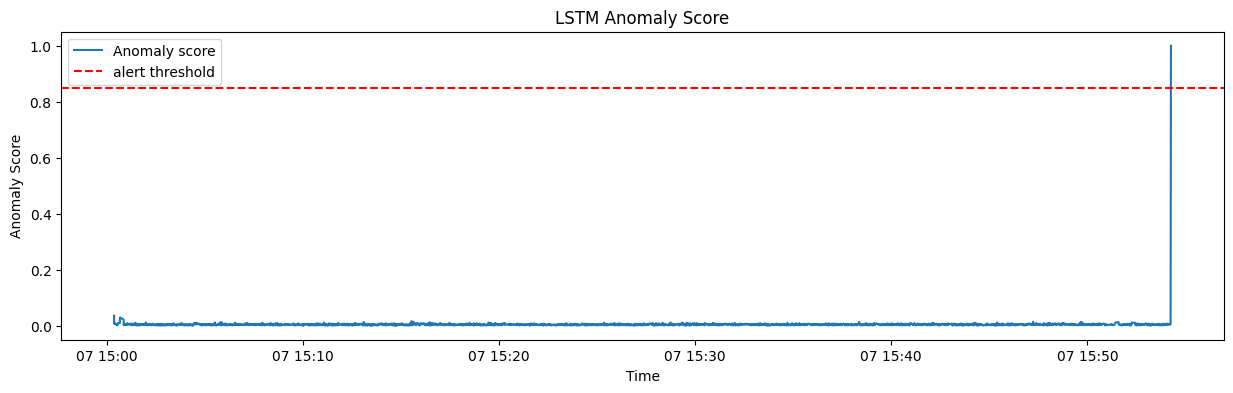

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.plot(score_times, lstm_score, label="Anomaly score")

plt.axhline(0.85, color="red", linestyle="--", label="alert threshold")

plt.title("LSTM Anomaly Score")
plt.xlabel("Time")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()


## 16. Warm-up ефект LSTM

На початкових кроках прихований стан LSTM
не містить інформації про поведінку користувача,
що призводить до підвищеної помилки.

Після кількох вікон модель стабілізується,
і оцінка аномальності стає надійною.


In [ ]:
WARMUP = 19

lstm_score = lstm_score[WARMUP:]
score_times = score_times[WARMUP:]


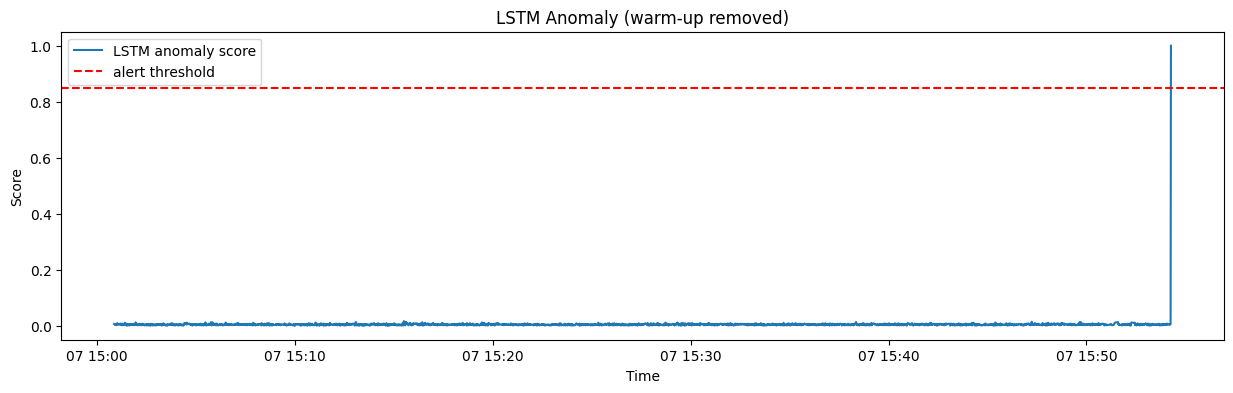

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(score_times, lstm_score, label="LSTM anomaly score")

plt.axhline(0.85, color="red", linestyle="--", label="alert threshold")

plt.title("LSTM Anomaly (warm-up removed)")
plt.xlabel("Time")
plt.ylabel("Score")
plt.legend()
plt.show()


In [ ]:
X_complex = generate_complex_attacks(X_scaled)
WINDOW = 30
STRIDE = 10
def build_sequences(X, window=30, stride=10):
    seqs = []
    for i in range(0, len(X)-window, stride):
        seqs.append(X[i:i+window])
    return np.stack(seqs)
seq_normal = build_sequences(X_scaled, WINDOW, STRIDE)
seq_attack = build_sequences(X_complex, WINDOW, STRIDE)


import torch

lstm.eval()

with torch.no_grad():
    rec_normal = lstm(
        torch.tensor(seq_normal, dtype=torch.float32).to(device)
    ).cpu().numpy()

    rec_attack = lstm(
        torch.tensor(seq_attack, dtype=torch.float32).to(device)
    ).cpu().numpy()
def recon_error(recon, original):
    return ((recon - original)**2).mean(axis=(1,2))

err_normal = recon_error(rec_normal, seq_normal)
err_attack = recon_error(rec_attack, seq_attack)

min_err = min(err_normal.min(), err_attack.min())
max_err = max(err_normal.max(), err_attack.max())

score_normal = (err_normal - min_err) / (max_err - min_err + 1e-9)
score_attack = (err_attack - min_err) / (max_err - min_err + 1e-9)


from sklearn.metrics import roc_auc_score

labels = np.concatenate([
    np.zeros(len(score_normal)),
    np.ones(len(score_attack))
])

scores = np.concatenate([
    score_normal,
    score_attack
])

print("LSTM Complex Attack AUC =", roc_auc_score(labels, scores))


LSTM Complex Attack AUC = 0.9999992097546382


In [ ]:
timeline_scores = np.concatenate([
    score_normal,
    score_attack
])

timeline_labels = np.concatenate([
    np.zeros(len(score_normal)),
    np.ones(len(score_attack))
])
time_axis = np.arange(len(timeline_scores))


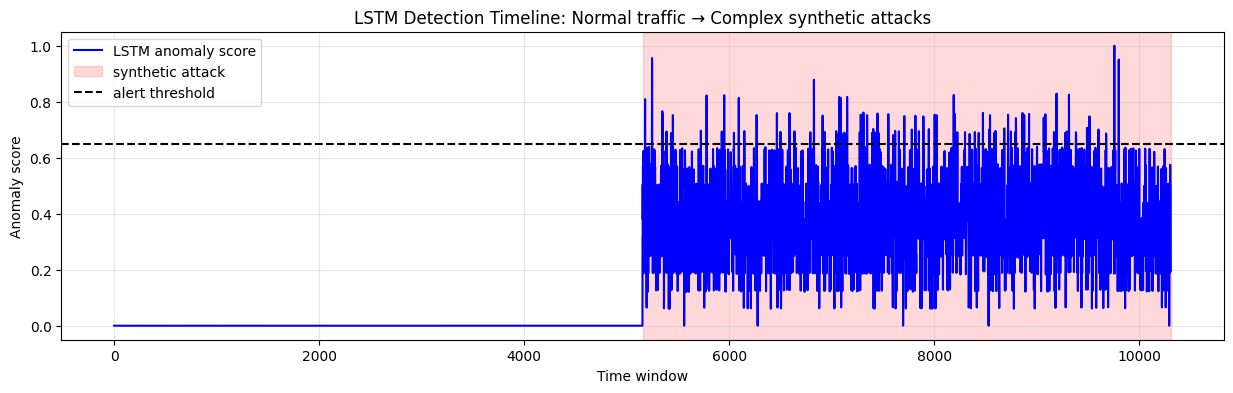

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

plt.plot(time_axis, timeline_scores, label="LSTM anomaly score", color="blue")

attack_start = len(score_normal)
plt.axvspan(attack_start, len(timeline_scores), color='red', alpha=0.15, label="synthetic attack")

plt.axhline(0.65, color="black", linestyle="--", label="alert threshold")

plt.title("LSTM Detection Timeline: Normal traffic → Complex synthetic attacks")
plt.xlabel("Time window")
plt.ylabel("Anomaly score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


---

## Збереження моделі:

In [ ]:
input_dim = seqs.shape[2]
print(input_dim)

torch.save({
    "model_state": lstm.state_dict(),
    "input_dim": input_dim,
    "window": WINDOW,
    "stride": STRIDE,
    "scaler": scaler,
    "label_encoders": encoders,
}, "weights.pt")


print("Saving LSTM AE:")
print("input_dim =", input_dim)
print("window =", WINDOW)
print("stride =", STRIDE)
print("model params =", sum(p.numel() for p in lstm.parameters()))



12
Saving LSTM AE:
input_dim = 12
window = 30
stride = 10
model params = 23712


## Висновок

Через відсутність якісно розмічених датасетів реального мережевого трафіку, unsupervised Autoencoder-підхід є  практично обґрунтованим та масштабованим рішенням.

Послідовні LSTM Autoencoder-моделі показують найвищу ефективність, особливо для складних і малопомітних атак, та придатні для використання в реальних системах IDS.
